In [2]:
# Re-import necessary library due to environment reset
import pandas as pd

# Load the uploaded dataset
file_path = 'mooc_dataset/big_student_clear_third_version.csv'

# Read the dataset
df = pd.read_csv(file_path)

# Display the first few rows to understand its structure
df.head()

,Unnamed: 0,institute,course_id,year,semester,userid_DI,viewed,explored,certified,final_cc_cname_DI,...,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,incomplete_flag,age
0,4,HarvardX,PH207x,2012,Fall,MHxPC130313697,0,0,0,India,...,0.0,2012-07-24,2013-07-27,6,3,197757,0,0,0,23
1,6,HarvardX,PH207x,2012,Fall,MHxPC130237753,1,0,0,United States,...,0.0,2012-07-24,2012-12-24,107,8,7,2,0,0,19
2,7,HarvardX,CS50x,2012,Summer,MHxPC130202970,1,0,0,United States,...,0.0,2012-07-24,2013-03-28,8,1,197757,1,0,0,24
3,20,HarvardX,CS50x,2012,Summer,MHxPC130223941,1,0,0,Other Middle East/Central Asia,...,0.0,2012-07-24,2013-07-15,25,2,197757,4,0,0,20
4,22,HarvardX,PH207x,2012,Fall,MHxPC130317399,0,0,0,Australia,...,0.0,2012-07-24,2012-08-25,3,2,197757,0,0,0,32


In [3]:
# Step 1: Inspect missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

gender    23211
dtype: int64

In [4]:
# Step 1: Filter active users (viewed or explored is 1)
active_users_df = df[(df["viewed"] == 1) | (df["explored"] == 1)]

# Step 2: Group transactions by userid_DI and include additional attributes
# Attributes to include in transactions: course_id, LoE_DI (education level), final_cc_cname_DI (country), and age
transactions_enriched = (
    active_users_df.groupby("userid_DI")
    .agg({
        "course_id": list,  # List of courses taken
        "LoE_DI": "first",  # Education level
        "final_cc_cname_DI": "first",  # Country
        "age": "first",  # Age
        "grade": "mean",  # Average grade
        "ndays_act": "mean",  # Average active days
        "nchapters": "mean",  # Average chapters
    })
    .reset_index()
)

# Step 3: Categorize continuous columns
# Categorize grade
transactions_enriched["grade_category"] = pd.cut(
    transactions_enriched["grade"], bins=[-1, 0.5, 0.8, 1], labels=["Low", "Medium", "High"]
)

# Categorize age
transactions_enriched["age_group"] = pd.cut(
    transactions_enriched["age"], bins=[0, 18, 25, 35, 50, 100], labels=["<18", "18-25", "26-35", "36-50", "50+"]
)

# Categorize ndays_act
transactions_enriched["activity_level"] = pd.cut(
    transactions_enriched["ndays_act"], bins=[-1, 5, 15, 30, 100], labels=["Low", "Medium", "High", "Very High"]
)



In [5]:
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Prepare data for mining
transactions_list = transactions_enriched["course_id"].tolist()

# One-hot encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
one_hot_encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori Algorithm with lower thresholds
frequent_itemsets_apriori = apriori(one_hot_encoded_df, min_support=0.001, use_colnames=True)

# Apply FP-Growth Algorithm with lower thresholds
frequent_itemsets_fpgrowth = fpgrowth(one_hot_encoded_df, min_support=0.001, use_colnames=True)

# Generate Association Rules for Apriori
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.1,num_itemsets=len(frequent_itemsets_apriori))

# Generate Association Rules for FP-Growth
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1,num_itemsets=len(frequent_itemsets_fpgrowth))

# Display the top rules for Apriori
print("Top Rules from Apriori:")
print(rules_apriori.sort_values(by="confidence", ascending=False).head(20))

# Display the top rules for FP-Growth
print("\nTop Rules from FP-Growth:")
print(rules_fpgrowth.sort_values(by="confidence", ascending=False).head(20))


Top Rules from Apriori:
               antecedents consequents  antecedent support  \
51  (8.02x, CS50x, 6.002x)     (6.00x)            0.001911   
10         (14.73x, CB22x)     (ER22x)            0.002407   
26         (CS50x, 6.002x)     (6.00x)            0.006982   
36          (8.02x, CS50x)     (6.00x)            0.005710   
46         (PH278x, CB22x)     (ER22x)            0.003035   
34          (7.00x, CS50x)     (6.00x)            0.003051   
49   (6.00x, 8.02x, CS50x)    (6.002x)            0.002531   
41          (7.00x, CB22x)     (ER22x)            0.002631   
17        (3.091x, 6.002x)     (6.00x)            0.002863   
43          (CS50x, CB22x)     (ER22x)            0.003723   
27          (8.02x, CS50x)    (6.002x)            0.005710   
50  (6.00x, 8.02x, 6.002x)     (CS50x)            0.003067   
37          (6.00x, CB22x)     (CS50x)            0.003167   
52  (6.00x, CS50x, 6.002x)     (8.02x)            0.003107   
21          (6.00x, 8.02x)    (6.002x)        

In [6]:
# Step 4: Filter rules based on thresholds
confidence_threshold = 0.25
lift_threshold = 0.5
support_threshold = 0.001

filtered_rules_apriori = rules_apriori[
    (rules_apriori['confidence'] > confidence_threshold) &
    (rules_apriori['lift'] > lift_threshold) &
    (rules_apriori['support'] > support_threshold)
]

# Step 5: Select top 10-20 rules by confidence
selected_rules_apriori = filtered_rules_apriori.sort_values(by='confidence', ascending=False).head(20)

# Display selected rules
print("Selected Rules:")
print(selected_rules_apriori.reset_index(drop=True))

Selected Rules:
               antecedents consequents  antecedent support  \
0   (8.02x, CS50x, 6.002x)     (6.00x)            0.001911   
1          (14.73x, CB22x)     (ER22x)            0.002407   
2          (CS50x, 6.002x)     (6.00x)            0.006982   
3           (8.02x, CS50x)     (6.00x)            0.005710   
4          (PH278x, CB22x)     (ER22x)            0.003035   
5           (7.00x, CS50x)     (6.00x)            0.003051   
6    (6.00x, 8.02x, CS50x)    (6.002x)            0.002531   
7           (7.00x, CB22x)     (ER22x)            0.002631   
8         (3.091x, 6.002x)     (6.00x)            0.002863   
9           (CS50x, CB22x)     (ER22x)            0.003723   
10          (8.02x, CS50x)    (6.002x)            0.005710   
11  (6.00x, 8.02x, 6.002x)     (CS50x)            0.003067   
12          (6.00x, CB22x)     (CS50x)            0.003167   
13  (6.00x, CS50x, 6.002x)     (8.02x)            0.003107   
14          (6.00x, 8.02x)    (6.002x)            0.00

In [7]:
# Define weightings for each metric
confidence_weight = 0.5
lift_weight = 0.3
support_weight = 0.2

# Add a composite score column
selected_rules_apriori['score'] = (
    selected_rules_apriori['confidence'] * confidence_weight +
    selected_rules_apriori['lift'] * lift_weight +
    selected_rules_apriori['support'] * support_weight
)

# Sort by the composite score
scored_rules = selected_rules_apriori.sort_values(by='score', ascending=False)

# Display the top scored rules
print(scored_rules[['antecedents', 'consequents', 'score']])


               antecedents consequents     score
52  (6.00x, CS50x, 6.002x)     (8.02x)  1.781101
29         (CS50x, 6.002x)     (8.02x)  1.485987
10         (14.73x, CB22x)     (ER22x)  1.422785
46         (PH278x, CB22x)     (ER22x)  1.299165
49   (6.00x, 8.02x, CS50x)    (6.002x)  1.274531
41          (7.00x, CB22x)     (ER22x)  1.149626
27          (8.02x, CS50x)    (6.002x)  1.059256
21          (6.00x, 8.02x)    (6.002x)  1.026956
43          (CS50x, CB22x)     (ER22x)  0.999123
50  (6.00x, 8.02x, 6.002x)     (CS50x)  0.813936
37          (6.00x, CB22x)     (CS50x)  0.809888
51  (8.02x, CS50x, 6.002x)     (6.00x)  0.754027
39          (6.00x, ER22x)     (CS50x)  0.749993
33          (7.00x, 6.00x)     (CS50x)  0.740873
26         (CS50x, 6.002x)     (6.00x)  0.629453
36          (8.02x, CS50x)     (6.00x)  0.626879
34          (7.00x, CS50x)     (6.00x)  0.583621
17        (3.091x, 6.002x)     (6.00x)  0.519249
19         (3.091x, 8.02x)     (6.00x)  0.420566
38          (CS50x, 

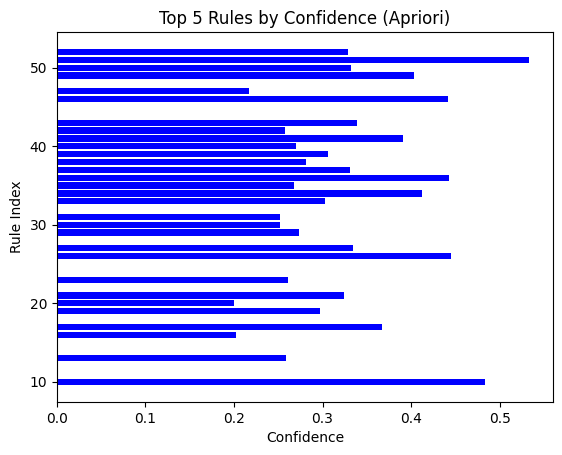

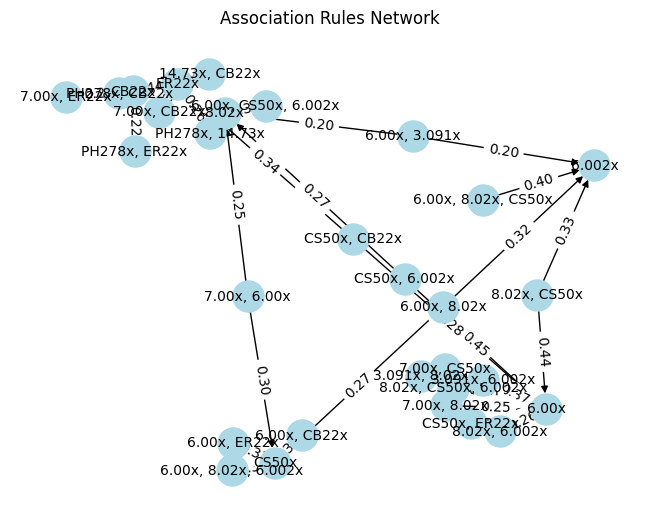

In [8]:
import matplotlib.pyplot as plt

# Bar chart for Apriori results
top_rules_apriori = rules_apriori.sort_values(by="confidence", ascending=False).head(30)
plt.barh(top_rules_apriori.index, top_rules_apriori['confidence'], color='blue')
plt.xlabel('Confidence')
plt.ylabel('Rule Index')
plt.title('Top 5 Rules by Confidence (Apriori)')
plt.show()

# Network graph for associations
import networkx as nx

G = nx.DiGraph()
for _, rule in top_rules_apriori.iterrows():
    G.add_edge(", ".join(rule['antecedents']), ", ".join(rule['consequents']),
               weight=rule['confidence'])

pos = nx.spring_layout(G)
weights = [G[u][v]['weight'] for u, v in G.edges]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in G.edges(data='weight')})
plt.title('Association Rules Network')
plt.show()
